# improve_data_label_v5.ipynb
v5: Train+Validation labels 활용 + 좌표 정규화 + 2-stage loss (Masked L1 → Kabsch) + Pairwise Distance Loss 보조목표 + Warmup/Cosine LR + Early Stopping

- 핵심 개선: Kabsch만으로는 학습 신호가 약해질 수 있어 residue 간 거리(distance map) MSE를 보조로 추가
- 결측/센티넬(-1e18 등)은 `abs(value) < 1e17` 조건으로 유효성 판정

In [1]:
# ==========================================
# 0) Imports & Device
# ==========================================
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [2]:
# ==========================================
# 1) Load CSVs
# ==========================================
train_seq = pd.read_csv("train_sequences.csv")
val_seq   = pd.read_csv("validation_sequences.csv")
test_seq  = pd.read_csv("test_sequences.csv")

train_labels = pd.read_csv("train_labels.csv", low_memory=False)
val_labels   = pd.read_csv("validation_labels.csv", low_memory=False)

print("train_seq:", train_seq.shape)
print("val_seq  :", val_seq.shape)
print("test_seq :", test_seq.shape)
print("train_labels:", train_labels.shape)
print("val_labels  :", val_labels.shape)

train_seq: (5716, 8)
val_seq  : (28, 8)
test_seq : (28, 8)
train_labels: (7794971, 8)
val_labels  : (9762, 126)


In [3]:
# ==========================================
# 2) Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['target_id'].astype(str).str.strip()
    df['tokenized'] = df['sequence'].apply(lambda x: [mapping.get(b, 0) for b in str(x)])
    return df

train_seq = tokenize_df(train_seq)
val_seq   = tokenize_df(val_seq)
test_seq  = tokenize_df(test_seq)

In [4]:
# ==========================================
# 3) Build coordinates + coord_mask from labels
# ==========================================
XYZ = ['x_1','y_1','z_1']
THRESH = 1e17

def _make_target_id_and_resid(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _make_target_id_and_resid(train_labels)
    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)
    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _make_target_id_and_resid(val_labels)

    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)
        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'] = chosen[:,0]
    df['y_1'] = chosen[:,1]
    df['z_1'] = chosen[:,2]
    df['coord_ok'] = ok_mask

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

print("train_coords:", train_coords.shape)
print("val_coords  :", val_coords.shape)

def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

print("train_coords NaN/Inf:", train_coords['coordinates'].apply(has_nan_inf).sum())
print("val_coords   NaN/Inf:", val_coords['coordinates'].apply(has_nan_inf).sum())

train_coords: (5716, 3)
val_coords  : (28, 3)
train_coords NaN/Inf: 0
val_coords   NaN/Inf: 0


In [5]:
# ==========================================
# 4) Build unified training dataframe: train_seq + val_seq + coords
# ==========================================
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_df = all_seq.merge(all_coords, on='target_id', how='inner')
print("all_df:", all_df.shape)

MAX_LEN = 256
all_df['valid_in_window'] = all_df['coord_mask'].apply(lambda m: float(np.sum(np.asarray(m, np.float32)[:MAX_LEN])))
print("valid_in_window stats:", all_df['valid_in_window'].describe())

MIN_VALID_IN_WINDOW = 30
before = len(all_df)
all_df = all_df[all_df['valid_in_window'] >= MIN_VALID_IN_WINDOW].copy()
print(f"Filtered all_df by valid_in_window>={MIN_VALID_IN_WINDOW}: {before} -> {len(all_df)}")

all_df: (5744, 11)
valid_in_window stats: count    5744.000000
mean      131.428099
std        97.004388
min         0.000000
25%        40.000000
50%        89.000000
75%       251.000000
max       256.000000
Name: valid_in_window, dtype: float64
Filtered all_df by valid_in_window>=30: 5744 -> 4749


In [6]:
# ==========================================
# 5) Dataset with per-sample coordinate normalization (centering + RMS scaling)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, sequences, coordinates, coord_masks, max_len=256):
        self.sequences = sequences
        self.coordinates = coordinates
        self.coord_masks = coord_masks
        self.max_len = max_len

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        coords = np.asarray(self.coordinates[idx], dtype=np.float32)
        c_mask = np.asarray(self.coord_masks[idx], dtype=np.float32)

        L = min(len(seq), coords.shape[0], c_mask.shape[0], self.max_len)
        seq = np.asarray(seq[:L], dtype=np.int64)
        coords = coords[:L]
        c_mask = c_mask[:L]
        valid = c_mask.astype(bool)

        if valid.sum() > 0:
            center = coords[valid].mean(axis=0, keepdims=True)
            coords = coords - center
            scale = np.sqrt((coords[valid]**2).sum(axis=1).mean())
            scale = max(float(scale), 1e-6)
            coords = coords / scale

        seq_p = np.zeros(self.max_len, dtype=np.int64)
        seq_p[:L] = seq

        coords_p = np.zeros((self.max_len, 3), dtype=np.float32)
        coords_p[:L] = coords

        mask = np.zeros(self.max_len, dtype=np.float32)
        mask[:L] = c_mask

        return (torch.tensor(seq_p, dtype=torch.long),
                torch.tensor(coords_p, dtype=torch.float32),
                torch.tensor(mask, dtype=torch.float32))

In [7]:
# ==========================================
# 6) Train/Holdout split
# ==========================================
idx_train, idx_hold = train_test_split(range(len(all_df)), test_size=0.1, random_state=42)
train_df = all_df.iloc[idx_train].reset_index(drop=True)
hold_df  = all_df.iloc[idx_hold].reset_index(drop=True)

train_dataset = RNADataset(train_df['tokenized'].values, train_df['coordinates'].values, train_df['coord_mask'].values, max_len=MAX_LEN)
hold_dataset  = RNADataset(hold_df['tokenized'].values, hold_df['coordinates'].values, hold_df['coord_mask'].values, max_len=MAX_LEN)

BATCH = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
hold_loader  = DataLoader(hold_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

print("train/hold:", len(train_dataset), len(hold_dataset))

train/hold: 4274 475


In [8]:
# ==========================================
# 7) Losses (Masked L1, Kabsch RMSD, Pairwise Distance MSE)
# ==========================================
def masked_l1_loss(preds, target, mask):
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)
    losses = []
    for k in range(K):
        pk = preds[:, k]
        diff = (pk - target).abs() * m
        denom = m.sum(dim=(1,2)).clamp_min(1.0)
        l1 = diff.sum(dim=(1,2)) / denom
        losses.append(l1)
    losses = torch.stack(losses, dim=1)
    min_loss, _ = torch.min(losses, dim=1)
    return min_loss.mean()

def kabsch_rotation(P, Q, mask=None):
    if mask is None:
        mask = torch.ones(P.shape[0], P.shape[1], device=P.device, dtype=P.dtype)
    mask_exp = mask.unsqueeze(-1)
    mask_sum = mask_exp.sum(dim=1, keepdim=True).clamp_min(1e-8)

    P_mean = (P * mask_exp).sum(dim=1, keepdim=True) / mask_sum
    Q_mean = (Q * mask_exp).sum(dim=1, keepdim=True) / mask_sum

    P_c = (P - P_mean) * mask_exp
    Q_c = (Q - Q_mean) * mask_exp

    H = torch.matmul(P_c.transpose(1,2), Q_c)
    U, S, Vh = torch.linalg.svd(H, full_matrices=False)
    V = Vh.transpose(1,2)

    det = torch.det(torch.matmul(V, U.transpose(1,2)))
    sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

    E = torch.eye(3, device=P.device, dtype=P.dtype).unsqueeze(0).repeat(P.shape[0],1,1)
    E[:,2,2] = sign
    R = torch.matmul(torch.matmul(V, E), U.transpose(1,2))

    P_aligned = torch.matmul(P_c, R.transpose(1,2)) + Q_mean
    return P_aligned * mask_exp

class KabschRMSDLoss(nn.Module):
    def forward(self, preds, target, mask):
        B, K, T, _ = preds.shape
        losses = []
        for k in range(K):
            pk = preds[:, k]
            pk_aligned = kabsch_rotation(pk, target, mask)
            diff_sq = (pk_aligned - target) ** 2
            sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1,2))
            n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)
            mse = sum_sq / n_valid
            rmsd = torch.sqrt(mse + 1e-8)
            losses.append(rmsd)
        losses = torch.stack(losses, dim=1)
        min_loss, _ = torch.min(losses, dim=1)
        return min_loss.mean()

def pairwise_distance_loss(preds, target, mask):
    B, K, T, _ = preds.shape
    m2 = mask.unsqueeze(1) * mask.unsqueeze(2)
    denom = m2.sum(dim=(1,2)).clamp_min(1.0)
    losses = []
    for k in range(K):
        pk = preds[:, k]
        d_pred = torch.cdist(pk, pk)
        d_true = torch.cdist(target, target)
        diff = (d_pred - d_true) ** 2 * m2
        mse = diff.sum(dim=(1,2)) / denom
        losses.append(mse)
    losses = torch.stack(losses, dim=1)
    min_loss, _ = torch.min(losses, dim=1)
    return min_loss.mean()

criterion_kabsch = KabschRMSDLoss()

In [9]:
# ==========================================
# 8) Model
# ==========================================
class RNATransformer(nn.Module):
    def __init__(self, n_tokens=5, d_model=256, nhead=8, num_layers=6, dropout=0.1, num_preds=5):
        super().__init__()
        self.embedding = nn.Embedding(n_tokens, d_model, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 2048, d_model))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.num_preds = num_preds
        self.head = nn.Linear(d_model, 3 * num_preds)

    def forward(self, tokens):
        B, T = tokens.shape
        pad_mask = (tokens == 0)
        x = self.embedding(tokens)
        x = x + self.pos_encoder[:, :T, :]
        x = self.encoder(x, src_key_padding_mask=pad_mask)
        out = self.head(x)
        out = out.view(B, T, self.num_preds, 3).permute(0,2,1,3)
        return out

model = RNATransformer().to(device)
print("Model ready.")

Model ready.


In [10]:
# ==========================================
# 9) Training (v5)
# ==========================================
epochs = 60
warmup_epochs = 5
DIST_W = 0.05
KEEP_MIN = 30

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)

total_steps = epochs * len(train_loader)
warmup_steps = int(0.05 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return (step + 1) / max(1, warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

best_val = float("inf")
patience = 7
stale = 0
best_path = "best_v5.pt"

def filter_batch(seq, target, mask, min_valid=KEEP_MIN):
    valid_counts = mask.sum(dim=1)
    keep = valid_counts >= min_valid
    if keep.sum() < 2:
        return None
    return seq[keep], target[keep], mask[keep]

for epoch in range(epochs):
    use_kabsch = (epoch >= warmup_epochs)
    stage = "KABSCH+DIST" if use_kabsch else "MASKED_L1"

    model.train()
    tr_sum, tr_steps = 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [{stage}]")
    for seq, target, mask in pbar:
        seq = seq.to(device); target = target.to(device); mask = mask.to(device)
        fb = filter_batch(seq, target, mask)
        if fb is None:
            continue
        seq, target, mask = fb

        optimizer.zero_grad(set_to_none=True)
        preds = model(seq)

        if use_kabsch:
            loss = criterion_kabsch(preds, target, mask) + DIST_W * pairwise_distance_loss(preds, target, mask)
        else:
            loss = masked_l1_loss(preds, target, mask)

        if not torch.isfinite(loss):
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        tr_sum += float(loss.item())
        tr_steps += 1
        pbar.set_postfix({"loss": float(loss.item()), "lr": optimizer.param_groups[0]["lr"]})

    tr_avg = tr_sum / max(1, tr_steps)

    model.eval()
    va_sum, va_steps = 0.0, 0
    with torch.no_grad():
        for seq, target, mask in hold_loader:
            seq = seq.to(device); target = target.to(device); mask = mask.to(device)
            fb = filter_batch(seq, target, mask)
            if fb is None:
                continue
            seq, target, mask = fb

            preds = model(seq)
            if use_kabsch:
                loss = criterion_kabsch(preds, target, mask) + DIST_W * pairwise_distance_loss(preds, target, mask)
            else:
                loss = masked_l1_loss(preds, target, mask)

            if not torch.isfinite(loss):
                continue
            va_sum += float(loss.item())
            va_steps += 1

    va_avg = va_sum / max(1, va_steps)
    print(f"[Epoch {epoch+1:02d}] stage={stage:11s} train={tr_avg:.6f} val={va_avg:.6f} steps={tr_steps}/{va_steps}")

    if va_avg < best_val - 1e-4:
        best_val = va_avg
        stale = 0
        torch.save(model.state_dict(), best_path)
        print(f"✅ best updated: {best_val:.6f}")
    else:
        stale += 1
        print(f"⏸ no improvement: {stale}/{patience}")
        if stale >= patience and use_kabsch:
            print("🛑 early stopping.")
            break

model.load_state_dict(torch.load(best_path, map_location=device))
print("Best model loaded:", best_path, "best_val=", best_val)

Epoch 1/60 [MASKED_L1]: 100%|██████████| 268/268 [00:16<00:00, 16.71it/s, loss=1.43, lr=1e-5]   
c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


[Epoch 01] stage=MASKED_L1   train=1.424784 val=1.389062 steps=268/30
✅ best updated: 1.389062


Epoch 2/60 [MASKED_L1]: 100%|██████████| 268/268 [00:16<00:00, 16.56it/s, loss=1.41, lr=2e-5]   


[Epoch 02] stage=MASKED_L1   train=1.400105 val=1.387580 steps=268/30
✅ best updated: 1.387580


Epoch 3/60 [MASKED_L1]: 100%|██████████| 268/268 [00:18<00:00, 14.25it/s, loss=1.38, lr=3e-5]   


[Epoch 03] stage=MASKED_L1   train=1.397428 val=1.389414 steps=268/30
⏸ no improvement: 1/7


Epoch 4/60 [MASKED_L1]: 100%|██████████| 268/268 [00:19<00:00, 13.79it/s, loss=1.42, lr=3e-5]


[Epoch 04] stage=MASKED_L1   train=1.395232 val=1.386754 steps=268/30
✅ best updated: 1.386754


Epoch 5/60 [MASKED_L1]: 100%|██████████| 268/268 [00:22<00:00, 11.96it/s, loss=1.39, lr=2.99e-5]


[Epoch 05] stage=MASKED_L1   train=1.393343 val=1.387601 steps=268/30
⏸ no improvement: 1/7


Epoch 6/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:00<00:00,  4.42it/s, loss=0.602, lr=2.98e-5]


[Epoch 06] stage=KABSCH+DIST train=0.608165 val=0.614719 steps=268/30
✅ best updated: 0.614719


Epoch 7/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:09<00:00,  3.85it/s, loss=0.59, lr=2.96e-5] 


[Epoch 07] stage=KABSCH+DIST train=0.603787 val=0.615162 steps=268/30
⏸ no improvement: 1/7


Epoch 8/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:23<00:00,  3.21it/s, loss=0.609, lr=2.94e-5]


[Epoch 08] stage=KABSCH+DIST train=0.602533 val=0.614876 steps=268/30
⏸ no improvement: 2/7


Epoch 9/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s, loss=0.609, lr=2.92e-5]


[Epoch 09] stage=KABSCH+DIST train=0.601851 val=0.615130 steps=268/30
⏸ no improvement: 3/7


Epoch 10/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:55<00:00,  2.33it/s, loss=0.606, lr=2.89e-5]


[Epoch 10] stage=KABSCH+DIST train=0.601577 val=0.614934 steps=268/30
⏸ no improvement: 4/7


Epoch 11/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:36<00:00,  7.25it/s, loss=0.604, lr=2.86e-5]


[Epoch 11] stage=KABSCH+DIST train=0.601506 val=0.615115 steps=268/30
⏸ no improvement: 5/7


Epoch 12/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:00<00:00,  4.45it/s, loss=0.602, lr=2.82e-5]


[Epoch 12] stage=KABSCH+DIST train=0.601309 val=0.614800 steps=268/30
⏸ no improvement: 6/7


Epoch 13/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:47<00:00,  2.50it/s, loss=0.593, lr=2.78e-5]


[Epoch 13] stage=KABSCH+DIST train=0.601236 val=0.614451 steps=268/30
✅ best updated: 0.614451


Epoch 14/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:00<00:00,  4.43it/s, loss=0.603, lr=2.73e-5]


[Epoch 14] stage=KABSCH+DIST train=0.600973 val=0.612403 steps=268/30
✅ best updated: 0.612403


Epoch 15/60 [KABSCH+DIST]: 100%|██████████| 268/268 [02:20<00:00,  1.91it/s, loss=0.523, lr=2.68e-5]


[Epoch 15] stage=KABSCH+DIST train=0.554923 val=0.514957 steps=268/30
✅ best updated: 0.514957


Epoch 16/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:10<00:00,  3.83it/s, loss=0.523, lr=2.63e-5]


[Epoch 16] stage=KABSCH+DIST train=0.502725 val=0.482123 steps=268/30
✅ best updated: 0.482123


Epoch 17/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:47<00:00,  2.49it/s, loss=0.448, lr=2.58e-5]


[Epoch 17] stage=KABSCH+DIST train=0.479811 val=0.455764 steps=268/30
✅ best updated: 0.455764


Epoch 18/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:12<00:00,  3.72it/s, loss=0.488, lr=2.52e-5]


[Epoch 18] stage=KABSCH+DIST train=0.459180 val=0.431975 steps=268/30
✅ best updated: 0.431975


Epoch 19/60 [KABSCH+DIST]: 100%|██████████| 268/268 [02:20<00:00,  1.91it/s, loss=0.453, lr=2.45e-5]


[Epoch 19] stage=KABSCH+DIST train=0.435637 val=0.403385 steps=268/30
✅ best updated: 0.403385


Epoch 20/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:36<00:00,  7.36it/s, loss=0.426, lr=2.39e-5]


[Epoch 20] stage=KABSCH+DIST train=0.410366 val=0.380325 steps=268/30
✅ best updated: 0.380325


Epoch 21/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:18<00:00, 14.47it/s, loss=0.314, lr=2.32e-5]


[Epoch 21] stage=KABSCH+DIST train=0.392452 val=0.366831 steps=268/30
✅ best updated: 0.366831


Epoch 22/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:21<00:00, 12.55it/s, loss=0.413, lr=2.25e-5]


[Epoch 22] stage=KABSCH+DIST train=0.380597 val=0.356212 steps=268/30
✅ best updated: 0.356212


Epoch 23/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:23<00:00, 11.28it/s, loss=0.413, lr=2.18e-5]


[Epoch 23] stage=KABSCH+DIST train=0.371447 val=0.350087 steps=268/30
✅ best updated: 0.350087


Epoch 24/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:26<00:00, 10.10it/s, loss=0.431, lr=2.1e-5] 


[Epoch 24] stage=KABSCH+DIST train=0.364860 val=0.348641 steps=268/30
✅ best updated: 0.348641


Epoch 25/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:00<00:00,  4.41it/s, loss=0.343, lr=2.03e-5]


[Epoch 25] stage=KABSCH+DIST train=0.359077 val=0.338669 steps=268/30
✅ best updated: 0.338669


Epoch 26/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:48<00:00,  5.50it/s, loss=0.255, lr=1.95e-5]


[Epoch 26] stage=KABSCH+DIST train=0.353793 val=0.336037 steps=268/30
✅ best updated: 0.336037


Epoch 27/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:48<00:00,  5.52it/s, loss=0.334, lr=1.87e-5]


[Epoch 27] stage=KABSCH+DIST train=0.349140 val=0.331900 steps=268/30
✅ best updated: 0.331900


Epoch 28/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:21<00:00,  3.29it/s, loss=0.349, lr=1.79e-5]


[Epoch 28] stage=KABSCH+DIST train=0.345140 val=0.330049 steps=268/30
✅ best updated: 0.330049


Epoch 29/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:10<00:00,  3.80it/s, loss=0.372, lr=1.71e-5]


[Epoch 29] stage=KABSCH+DIST train=0.342101 val=0.325584 steps=268/30
✅ best updated: 0.325584


Epoch 30/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:24<00:00,  3.19it/s, loss=0.237, lr=1.62e-5]


[Epoch 30] stage=KABSCH+DIST train=0.338355 val=0.322800 steps=268/30
✅ best updated: 0.322800


Epoch 31/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:12<00:00,  3.72it/s, loss=0.348, lr=1.54e-5]


[Epoch 31] stage=KABSCH+DIST train=0.335949 val=0.320318 steps=268/30
✅ best updated: 0.320318


Epoch 32/60 [KABSCH+DIST]: 100%|██████████| 268/268 [02:07<00:00,  2.10it/s, loss=0.353, lr=1.46e-5]


[Epoch 32] stage=KABSCH+DIST train=0.333418 val=0.317685 steps=268/30
✅ best updated: 0.317685


Epoch 33/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:47<00:00,  2.50it/s, loss=0.476, lr=1.38e-5]


[Epoch 33] stage=KABSCH+DIST train=0.331397 val=0.316035 steps=268/30
✅ best updated: 0.316035


Epoch 34/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:25<00:00, 10.43it/s, loss=0.218, lr=1.29e-5]


[Epoch 34] stage=KABSCH+DIST train=0.328310 val=0.314001 steps=268/30
✅ best updated: 0.314001


Epoch 35/60 [KABSCH+DIST]: 100%|██████████| 268/268 [02:11<00:00,  2.03it/s, loss=0.408, lr=1.21e-5]


[Epoch 35] stage=KABSCH+DIST train=0.327105 val=0.312281 steps=268/30
✅ best updated: 0.312281


Epoch 36/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:07<00:00,  3.98it/s, loss=0.163, lr=1.13e-5]


[Epoch 36] stage=KABSCH+DIST train=0.324089 val=0.310304 steps=268/30
✅ best updated: 0.310304


Epoch 37/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:00<00:00,  4.41it/s, loss=0.474, lr=1.05e-5]


[Epoch 37] stage=KABSCH+DIST train=0.323654 val=0.308837 steps=268/30
✅ best updated: 0.308837


Epoch 38/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:35<00:00,  2.80it/s, loss=0.255, lr=9.74e-6]


[Epoch 38] stage=KABSCH+DIST train=0.321319 val=0.308787 steps=268/30
⏸ no improvement: 1/7


Epoch 39/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:39<00:00,  6.74it/s, loss=0.323, lr=8.97e-6]


[Epoch 39] stage=KABSCH+DIST train=0.320329 val=0.307436 steps=268/30
✅ best updated: 0.307436


Epoch 40/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:52<00:00,  2.39it/s, loss=0.276, lr=8.23e-6]


[Epoch 40] stage=KABSCH+DIST train=0.318662 val=0.305743 steps=268/30
✅ best updated: 0.305743


Epoch 41/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:14<00:00,  3.62it/s, loss=0.38, lr=7.5e-6]  


[Epoch 41] stage=KABSCH+DIST train=0.318096 val=0.305100 steps=268/30
✅ best updated: 0.305100


Epoch 42/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:18<00:00,  3.43it/s, loss=0.486, lr=6.8e-6] 


[Epoch 42] stage=KABSCH+DIST train=0.317253 val=0.303764 steps=268/30
✅ best updated: 0.303764


Epoch 43/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:24<00:00,  3.19it/s, loss=0.177, lr=6.12e-6]


[Epoch 43] stage=KABSCH+DIST train=0.315693 val=0.302979 steps=268/30
✅ best updated: 0.302979


Epoch 44/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:23<00:00,  3.21it/s, loss=0.323, lr=5.46e-6]


[Epoch 44] stage=KABSCH+DIST train=0.314846 val=0.302038 steps=268/30
✅ best updated: 0.302038


Epoch 45/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:46<00:00,  2.51it/s, loss=0.169, lr=4.84e-6]


[Epoch 45] stage=KABSCH+DIST train=0.313783 val=0.301805 steps=268/30
✅ best updated: 0.301805


Epoch 46/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:35<00:00,  2.82it/s, loss=0.339, lr=4.25e-6]


[Epoch 46] stage=KABSCH+DIST train=0.313801 val=0.301193 steps=268/30
✅ best updated: 0.301193


Epoch 47/60 [KABSCH+DIST]: 100%|██████████| 268/268 [02:14<00:00,  1.99it/s, loss=0.291, lr=3.69e-6]


[Epoch 47] stage=KABSCH+DIST train=0.312919 val=0.300609 steps=268/30
✅ best updated: 0.300609


Epoch 48/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:15<00:00,  3.54it/s, loss=0.305, lr=3.16e-6]


[Epoch 48] stage=KABSCH+DIST train=0.312354 val=0.300363 steps=268/30
✅ best updated: 0.300363


Epoch 49/60 [KABSCH+DIST]: 100%|██████████| 268/268 [02:33<00:00,  1.74it/s, loss=0.215, lr=2.67e-6]


[Epoch 49] stage=KABSCH+DIST train=0.311650 val=0.299708 steps=268/30
✅ best updated: 0.299708


Epoch 50/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:35<00:00,  2.80it/s, loss=0.385, lr=2.22e-6]


[Epoch 50] stage=KABSCH+DIST train=0.311770 val=0.299190 steps=268/30
✅ best updated: 0.299190


Epoch 51/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:08<00:00,  3.91it/s, loss=0.437, lr=1.81e-6]


[Epoch 51] stage=KABSCH+DIST train=0.311708 val=0.298990 steps=268/30
✅ best updated: 0.298990


Epoch 52/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:12<00:00,  3.72it/s, loss=0.229, lr=1.43e-6]


[Epoch 52] stage=KABSCH+DIST train=0.310481 val=0.299004 steps=268/30
⏸ no improvement: 1/7


Epoch 53/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:43<00:00,  6.22it/s, loss=0.287, lr=1.1e-6] 


[Epoch 53] stage=KABSCH+DIST train=0.310669 val=0.298697 steps=268/30
✅ best updated: 0.298697


Epoch 54/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:18<00:00, 14.42it/s, loss=0.351, lr=8.13e-7]


[Epoch 54] stage=KABSCH+DIST train=0.310493 val=0.298590 steps=268/30
✅ best updated: 0.298590


Epoch 55/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:20<00:00, 13.23it/s, loss=0.267, lr=5.66e-7]


[Epoch 55] stage=KABSCH+DIST train=0.310015 val=0.298465 steps=268/30
✅ best updated: 0.298465


Epoch 56/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:22<00:00, 12.10it/s, loss=0.35, lr=3.63e-7] 


[Epoch 56] stage=KABSCH+DIST train=0.310289 val=0.298412 steps=268/30
⏸ no improvement: 1/7


Epoch 57/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:21<00:00, 12.28it/s, loss=0.293, lr=2.05e-7]


[Epoch 57] stage=KABSCH+DIST train=0.310287 val=0.298285 steps=268/30
✅ best updated: 0.298285


Epoch 58/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:25<00:00, 10.44it/s, loss=0.262, lr=9.1e-8] 


[Epoch 58] stage=KABSCH+DIST train=0.309724 val=0.298234 steps=268/30
⏸ no improvement: 1/7


Epoch 59/60 [KABSCH+DIST]: 100%|██████████| 268/268 [00:48<00:00,  5.49it/s, loss=0.282, lr=2.28e-8]


[Epoch 59] stage=KABSCH+DIST train=0.309737 val=0.298242 steps=268/30
⏸ no improvement: 2/7


Epoch 60/60 [KABSCH+DIST]: 100%|██████████| 268/268 [01:23<00:00,  3.20it/s, loss=0.157, lr=0]       


[Epoch 60] stage=KABSCH+DIST train=0.309442 val=0.298248 steps=268/30
⏸ no improvement: 3/7
Best model loaded: best_v5.pt best_val= 0.29828451772530873


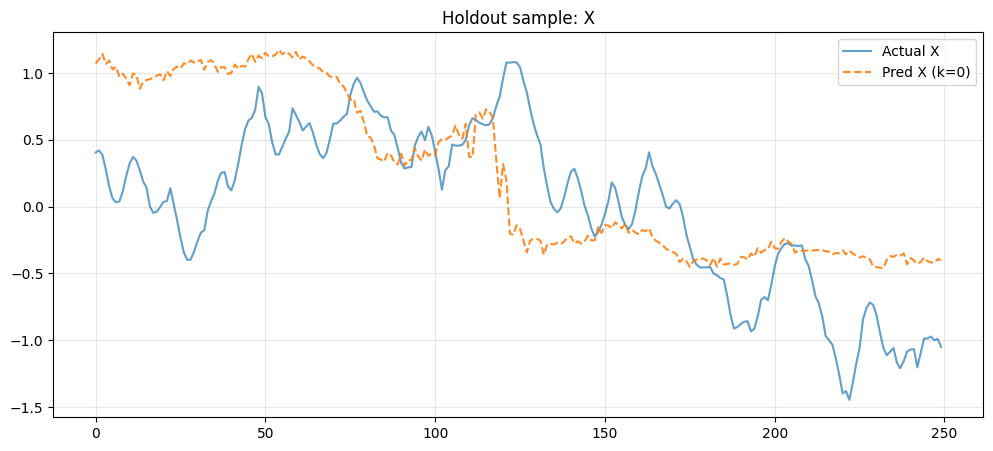

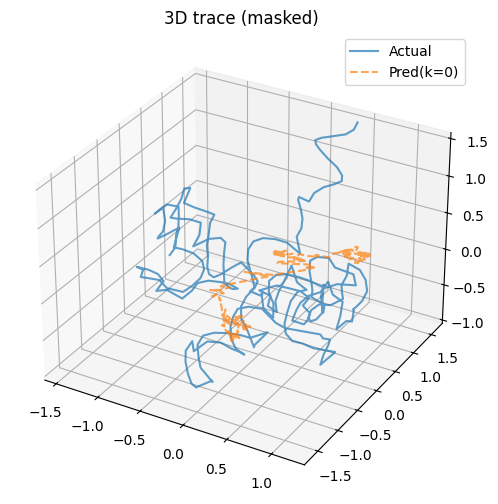

In [11]:
# ==========================================
# 10) Quick visualization on holdout batch (k=0)
# ==========================================
model.eval()
seq_b, tgt_b, m_b = next(iter(hold_loader))
seq_b = seq_b.to(device); tgt_b = tgt_b.to(device); m_b = m_b.to(device)
with torch.no_grad():
    pred_b = model(seq_b)

mask0 = m_b[0].detach().cpu().numpy().astype(bool)
t0 = tgt_b[0].detach().cpu().numpy()[mask0]
p0 = pred_b[0,0].detach().cpu().numpy()[mask0]

plt.figure(figsize=(12,5))
plt.plot(t0[:,0], label="Actual X", alpha=0.7)
plt.plot(p0[:,0], label="Pred X (k=0)", linestyle="--", alpha=0.9)
plt.legend(); plt.grid(alpha=0.3); plt.title("Holdout sample: X"); plt.show()

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(t0[:,0], t0[:,1], t0[:,2], label="Actual", alpha=0.7)
ax.plot(p0[:,0], p0[:,1], p0[:,2], label="Pred(k=0)", alpha=0.7, linestyle="--")
ax.legend(); ax.set_title("3D trace (masked)")
plt.show()